In [1]:
movie <- read.csv("E:/Machine Learning/Datasets/Movie_classification.csv", header = TRUE)
dim(movie)

[1] 506  19

In [2]:
summary(movie)

 Marketing.expense Production.expense Multiplex.coverage     Budget     
 Min.   :  20.13   Min.   : 55.92     Min.   :0.1290     Min.   :19781  
 1st Qu.:  21.64   1st Qu.: 65.38     1st Qu.:0.3760     1st Qu.:32694  
 Median :  25.13   Median : 74.38     Median :0.4620     Median :34488  
 Mean   :  92.27   Mean   : 77.27     Mean   :0.4453     Mean   :34911  
 3rd Qu.:  93.54   3rd Qu.: 91.20     3rd Qu.:0.5510     3rd Qu.:36794  
 Max.   :1799.52   Max.   :110.48     Max.   :0.6150     Max.   :48773  
                                                                        
  Movie_length   Lead_.Actor_Rating Lead_Actress_rating Director_rating
 Min.   : 76.4   Min.   :3.840      Min.   :4.035       Min.   :3.840  
 1st Qu.:118.5   1st Qu.:7.316      1st Qu.:7.504       1st Qu.:7.296  
 Median :151.0   Median :8.307      Median :8.495       Median :8.312  
 Mean   :142.1   Mean   :8.014      Mean   :8.186       Mean   :8.020  
 3rd Qu.:167.6   3rd Qu.:8.865      3rd Qu.:9.030       

In [3]:
# The Time_taken variable has missing values. So we do missing value imputation
movie$Time_taken[is.na(movie$Time_taken)] <- mean(movie$Time_taken, na.rm=TRUE)
sum(is.na(movie))

[1] 0

# Test-Train Split

In [4]:
library(caTools)
set.seed(0)
split <- sample.split(movie,SplitRatio = 0.8)
trainc <- subset(movie, split==TRUE)
testc <- subset(movie, split==FALSE)

In [5]:
dim(trainc)
dim(testc)

[1] 399  19

[1] 107  19

In [6]:
# Since we are doing classification, we'll require to convert Start_Tech_Oscar to a factor
trainc$Start_Tech_Oscar <- as.factor(trainc$Start_Tech_Oscar)
testc$Start_Tech_Oscar <- as.factor(testc$Start_Tech_Oscar)
trainc$X3D_available <- as.factor(trainc$X3D_available)
testc$X3D_available <- as.factor(testc$X3D_available)
trainc$Genre <- as.factor(trainc$Genre)
testc$Genre <- as.factor(testc$Genre)

# Decision Tree

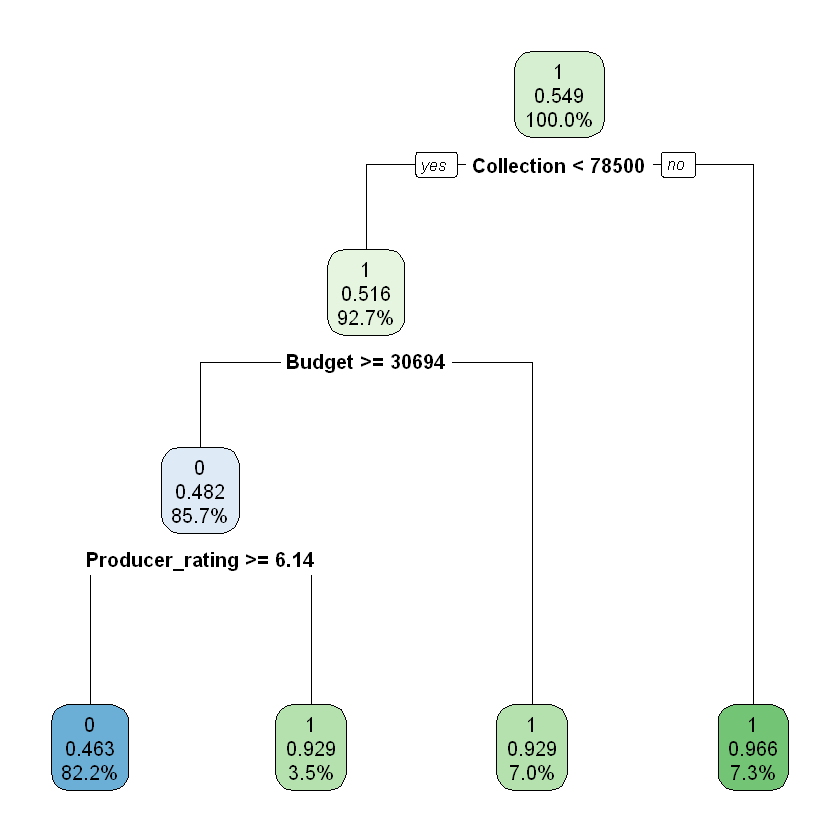

In [8]:
library(rpart)
library(rpart.plot)
classtree <- rpart(Start_Tech_Oscar~., data=trainc, method="class", control=rpart.control(maxdepth = 3))
rpart.plot(classtree, digits=-3)

In [9]:
printcp(classtree)


Classification tree:
rpart(formula = Start_Tech_Oscar ~ ., data = trainc, method = "class", 
    control = rpart.control(maxdepth = 3))

Variables actually used in tree construction:
[1] Budget          Collection      Producer_rating

Root node error: 180/399 = 0.45113

n= 399 

        CP nsplit rel error xerror     xstd
1 0.044444      0   1.00000 1.0000 0.055220
2 0.010000      3   0.86667 1.0944 0.055482


In [10]:
# Predicting values on testc set
testc$classtree <- predict(classtree, testc, type="class")
table(testc$Start_Tech_Oscar, testc$classtree)

   
     0  1
  0 45  5
  1 38 19

In [11]:
64/107*100

[1] 59.81308

We need not prune the tree as the accuracy is slightly better in prediction accuracy

# Bagging

In [12]:
library(randomForest)
set.seed(0)
trainc$Start_Tech_Oscar <- as.factor(trainc$Start_Tech_Oscar)
bagging <- randomForest(Start_Tech_Oscar~., data=trainc, method="class", mtry=17)
testc$bagging <- predict(bagging, testc, type="response")
table(testc$Start_Tech_Oscar, testc$bagging)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



   
     0  1
  0 29 21
  1 14 43

In [13]:
72/107*100

[1] 67.28972

# Random Forest

In [14]:
set.seed(0)
randomforest <- randomForest(Start_Tech_Oscar~., data=trainc, ntree=500)
testc$randomforest <- predict(randomforest, testc, type="class")
table(testc$Start_Tech_Oscar, testc$randomforest) 

   
     0  1
  0 27 23
  1 18 39

In [15]:
66/107*100

[1] 61.68224

In [16]:
library(gbm)
set.seed(0)
gradient <- gbm(Start_Tech_Oscar~., data=trainc, distribution="multinomial", n.trees=1000, interaction.depth=4, shrinkage=0.2, verbose = F)
testc$gradient <- predict(gradient, testc, n.trees=1000, type="response")
class_names = colnames(testc$gradient)[apply(testc$gradient, 1, which.max)]
table(testc$Start_Tech_Oscar, as.factor(class_names))

Loaded gbm 2.1.8.1

Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."


   
     0  1
  0 25 25
  1 20 37

In [17]:
62/107*100

[1] 57.94393

# Adaptive Boost

In [18]:
library(adabag)
adaboost <- boosting(Start_Tech_Oscar~., data=trainc, boos=TRUE)
predada <- predict(adaboost, testc)
table(predada$class, testc$Start_Tech_Oscar) 

Loading required package: caret

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice

Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel



   
     0  1
  0 30 18
  1 20 39

In [19]:
69/107*100

[1] 64.48598

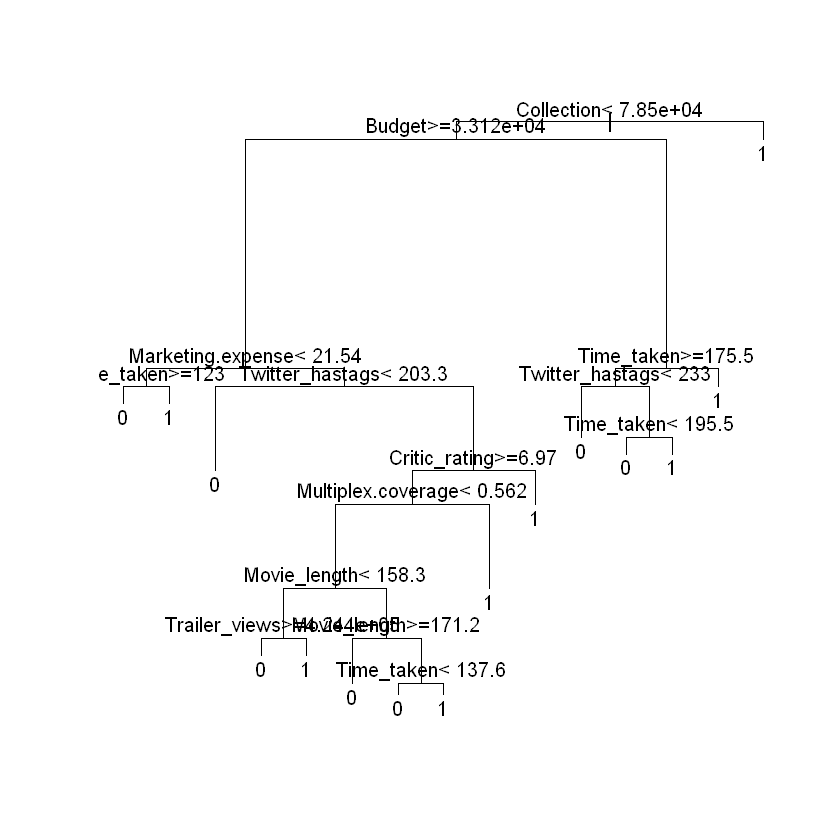

In [20]:
t1 <- adaboost$trees[[1]]
plot(t1)
text(t1, pretty=100)

# XG Boost

In [7]:
library(xgboost)
trainY <- trainc$Start_Tech_Oscar=="1"
trainX <- model.matrix(Start_Tech_Oscar~.-1, data=trainc)
trainX <- trainX[,-12]

testY <- testc$Start_Tech_Oscar=="1"
testX <- model.matrix(Start_Tech_Oscar~.-1, data=testc)
testX <- testX[,-12]

Xmatrix_train <- xgb.DMatrix(data=trainX, label=trainY)
Xmatrix_test <- xgb.DMatrix(data=testX, label=testY)

Xgboosting <- xgboost(data=Xmatrix_train, nround=50, objective ="multi:softmax", eta=0.3, num_class=2, max_depth=100)
xgpred <- predict(Xgboosting, Xmatrix_test)
table(testY, xgpred)

[1]	train-mlogloss:0.506756 
[2]	train-mlogloss:0.401487 
[3]	train-mlogloss:0.315490 
[4]	train-mlogloss:0.256459 
[5]	train-mlogloss:0.209795 
[6]	train-mlogloss:0.175916 
[7]	train-mlogloss:0.150885 
[8]	train-mlogloss:0.130334 
[9]	train-mlogloss:0.113675 
[10]	train-mlogloss:0.100119 
[11]	train-mlogloss:0.089515 
[12]	train-mlogloss:0.081753 
[13]	train-mlogloss:0.074419 
[14]	train-mlogloss:0.068095 
[15]	train-mlogloss:0.062626 
[16]	train-mlogloss:0.058346 
[17]	train-mlogloss:0.054328 
[18]	train-mlogloss:0.050960 
[19]	train-mlogloss:0.048015 
[20]	train-mlogloss:0.044911 
[21]	train-mlogloss:0.042852 
[22]	train-mlogloss:0.040494 
[23]	train-mlogloss:0.038455 
[24]	train-mlogloss:0.036670 
[25]	train-mlogloss:0.035095 
[26]	train-mlogloss:0.033451 
[27]	train-mlogloss:0.032290 
[28]	train-mlogloss:0.031226 
[29]	train-mlogloss:0.030154 
[30]	train-mlogloss:0.029058 
[31]	train-mlogloss:0.028062 
[32]	train-mlogloss:0.027287 
[33]	train-mlogloss:0.026444 
[34]	train-mlogloss

       xgpred
testY    0  1
  FALSE 27 23
  TRUE  16 41

In [7]:
68/107*100

[1] 63.5514

# Support Vector Machines

### 1. Linear Kernel

In [21]:
library (e1071)
svmfit = svm (Start_Tech_Oscar~., data=trainc , kernel = "linear", cost =1 ,scale = TRUE)
summary (svmfit)


Call:
svm(formula = Start_Tech_Oscar ~ ., data = trainc, kernel = "linear", 
    cost = 1, scale = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  293

 ( 149 144 )


Number of Classes:  2 

Levels: 
 0 1




In [22]:
testc$linearsvm=predict (svmfit ,testc)
table(predict=testc$linearsvm, truth= testc$Start_Tech_Oscar) 

       truth
predict  0  1
      0 30 21
      1 20 36

In [28]:
66/107*100

[1] 61.68224

In [24]:
## To check the support vectors
svmfit$index

[1]   1   7  12  13  14  18  23  24  26  28  30  36  37  47  48  49  50  52
 [19]  53  55  57  58  59  60  61  62  65  66  69  72  79  80  84  85  86  87
 [37]  88  98  99 100 102 103 104 105 112 113 120 121 126 141 144 149 151 158
 [55] 159 160 161 163 169 174 175 176 177 178 182 184 186 188 189 190 192 196
 [73] 197 201 203 207 210 211 217 218 219 220 223 227 229 233 238 240 241 247
 [91] 248 250 251 253 256 257 258 260 266 267 268 269 270 278 280 281 283 284
[109] 285 286 288 298 300 303 304 307 309 311 312 325 329 331 333 335 339 343
[127] 345 347 350 352 354 355 357 361 364 367 369 373 374 376 378 379 380 382
[145] 383 384 386 392 393   2   5   8   9  10  15  16  19  20  21  22  25  27
[163]  31  32  33  34  35  40  41  43  54  56  63  64  68  71  74  75  76  78
[181]  81  82  83  92  93  94  96 106 107 108 109 110 115 116 119 122 123 130
[199] 131 133 134 135 137 138 140 146 147 150 152 153 154 156 157 164 171 173
[217] 180 183 191 193 195 198 199 204 205 206 209 213 214 215 216 221 226 228
[235] 230 231 232 234 236 237 239 242 243 244 246 249 252 254 255 259 261 264
[253] 265 272 273 274 276 282 301 302 308 314 316 317 319 320 324 341 346 349
[271] 351 353 356 358 359 360 362 363 365 366 368 371 372 377 381 385 388 389
[289] 390 391 395 396 398

In [25]:
## Finding best value of cost / Tuning the hyperparameter
set.seed (0)
tune.out = tune(svm, Start_Tech_Oscar~.,data=trainc ,kernel="linear", ranges =list(cost=c(0.001 , 0.01, 0.1, 1,10,100)))
bestmod = tune.out$best.model
summary(bestmod)


Call:
best.tune(METHOD = svm, train.x = Start_Tech_Oscar ~ ., data = trainc, 
    ranges = list(cost = c(0.001, 0.01, 0.1, 1, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  293

 ( 149 144 )


Number of Classes:  2 

Levels: 
 0 1




In [27]:
testc$tunedlinear=predict (bestmod ,testc)
table(predict=testc$tunedlinear, truth=testc$Start_Tech_Oscar)

       truth
predict  0  1
      0 30 21
      1 20 36

In [29]:
66/107*100

[1] 61.68224

### 2. Polynomial Kernel

In [30]:
svmfitP = svm(Start_Tech_Oscar~., data=trainc , kernel ="polynomial", cost=1, degree=2)
# Hyperparameter Tuning
tune.outP=tune(svm ,Start_Tech_Oscar~.,data=trainc, cross = 4, kernel="polynomial", ranges =list(cost=c(0.001,0.1, 1,5,10),degree=c(0.5,1,2,3,5) ))
bestmodP =tune.outP$best.model
summary(bestmodP)


Call:
best.tune(METHOD = svm, train.x = Start_Tech_Oscar ~ ., data = trainc, 
    ranges = list(cost = c(0.001, 0.1, 1, 5, 10), degree = c(0.5, 
        1, 2, 3, 5)), cross = 4, kernel = "polynomial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  5 
     degree:  1 
     coef.0:  0 

Number of Support Vectors:  308

 ( 157 151 )


Number of Classes:  2 

Levels: 
 0 1

4-fold cross-validation on training data:

Total Accuracy: 64.41103 
Single Accuracies:
 66.66667 68 59 64 




In [31]:
testc$poly = predict(bestmodP,testc)
table(predict=testc$poly, truth=testc$Start_Tech_Oscar)

       truth
predict  0  1
      0 29 21
      1 21 36

In [32]:
65/107*100

[1] 60.74766

The best model comes at cost=5 and degree=1. This indicates that there is a linear relationship between Start_Tech_Oscar and other variables


### 3. Radial Kernel

In [33]:
svmfitR = svm(Start_Tech_Oscar~., data=trainc , kernel = "radial", gamma =1, cost =1)
tune.outR = tune(svm ,Start_Tech_Oscar~.,data=trainc ,kernel="radial", ranges = list(cost=c(0.001, 0.01,0.1 ,1 ,10 ,100 ,1000), gamma=c(0.01, 0.1,0.5,1,2,3,4,10, 50) ))
summary(tune.outR)
bestmodR =tune.outR$best.model
summary(bestmodR)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10   0.5

- best performance: 0.3558333 

- Detailed performance results:
    cost gamma     error dispersion
1  1e-03  0.01 0.4514103 0.06055255
2  1e-02  0.01 0.4514103 0.06055255
3  1e-01  0.01 0.4514103 0.06055255
4  1e+00  0.01 0.4014103 0.08459693
5  1e+01  0.01 0.3884615 0.06249918
6  1e+02  0.01 0.4234615 0.06748024
7  1e+03  0.01 0.4210897 0.06006094
8  1e-03  0.10 0.4514103 0.06055255
9  1e-02  0.10 0.4514103 0.06055255
10 1e-01  0.10 0.4514103 0.06055255
11 1e+00  0.10 0.3833974 0.06416269
12 1e+01  0.10 0.4057692 0.09170476
13 1e+02  0.10 0.3933974 0.08291372
14 1e+03  0.10 0.3933974 0.08291372
15 1e-03  0.50 0.4514103 0.06055255
16 1e-02  0.50 0.4514103 0.06055255
17 1e-01  0.50 0.4514103 0.06055255
18 1e+00  0.50 0.3659615 0.06392315
19 1e+01  0.50 0.3558333 0.05583955
20 1e+02  0.50 0.3558333 0.05583955
21 1e+03  0.50 0.3558333 0.05583955
22 1e-03  1.00 0.4514103 


Call:
best.tune(METHOD = svm, train.x = Start_Tech_Oscar ~ ., data = trainc, 
    ranges = list(cost = c(0.001, 0.01, 0.1, 1, 10, 100, 1000), gamma = c(0.01, 
        0.1, 0.5, 1, 2, 3, 4, 10, 50)), kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  399

 ( 219 180 )


Number of Classes:  2 

Levels: 
 0 1




In [34]:
testc$radial=predict (bestmodR,testc)
table(predict=testc$radial, truth=testc$Start_Tech_Oscar)

       truth
predict  0  1
      0 19 18
      1 31 39

In [35]:
58/107*100

[1] 54.20561

# Conclusion

The bagging model provides the best accuracy on the test set as 67.28% and it is best for predicting whether a movie has won an oscar or not